#### Import Libraries

In [1]:
import torch
import json
from haystack.preprocessor.cleaning import clean_wiki_text
from haystack.preprocessor.preprocessor import PreProcessor
from haystack.preprocessor.utils import convert_files_to_dicts, fetch_archive_from_http, eval_data_from_json
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
from haystack.document_store import InMemoryDocumentStore
from haystack.retriever.sparse import TfidfRetriever
from haystack.utils import print_answers
from haystack.reader.farm import FARMReader
from haystack.pipeline import ExtractiveQAPipeline

06/28/2021 21:53:39 - INFO - faiss.loader -   Loading faiss with AVX2 support.
06/28/2021 21:53:39 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
06/28/2021 21:53:39 - INFO - faiss.loader -   Loading faiss.
06/28/2021 21:53:40 - INFO - farm.modeling.prediction_head -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
06/28/2021 21:53:41 - INFO - faiss.loader -   Loading faiss with AVX2 support.
06/28/2021 21:53:41 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
06/28/2021 21:53:41 - INFO - faiss.loader -   Loading faiss.


In [2]:
# Clear Cuda memory

import gc

gc.collect()

torch.cuda.empty_cache()

#### Check Cuda

In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1050


#### Get documents

In [4]:
all_docs = convert_files_to_dicts(dir_path="gem_explorer")
preprocessor = PreProcessor(
    clean_empty_lines=True,
    clean_whitespace=True,
    clean_header_footer=False,
    split_by="word",
    split_length=100,
    split_respect_sentence_boundary=True
)

def clean_unicode(text):
    return text.replace("\u200b","")

nested_docs = [preprocessor.process(d) for d in all_docs]
docs = [d for x in nested_docs for d in x]
for doc in docs:
    doc['text'] = clean_unicode(doc['text'])
document_list  = [doc['text'] for doc in docs]

06/28/2021 21:53:41 - INFO - haystack.preprocessor.utils -   Converting gem_explorer\after_applying\acceptance_letter.txt
06/28/2021 21:53:41 - INFO - haystack.preprocessor.utils -   Converting gem_explorer\after_applying\participation_letter.txt
06/28/2021 21:53:41 - INFO - haystack.preprocessor.utils -   Converting gem_explorer\back_ntu\credit_transfer.txt
06/28/2021 21:53:41 - INFO - haystack.preprocessor.utils -   Converting gem_explorer\back_ntu\post_exchange_review.txt
06/28/2021 21:53:41 - INFO - haystack.preprocessor.utils -   Converting gem_explorer\back_ntu\reenroll_courses.txt
06/28/2021 21:53:41 - INFO - haystack.preprocessor.utils -   Converting gem_explorer\back_ntu\transcripts.txt
06/28/2021 21:53:41 - INFO - haystack.preprocessor.utils -   Converting gem_explorer\before_applying\allocation_criteria.txt
06/28/2021 21:53:41 - INFO - haystack.preprocessor.utils -   Converting gem_explorer\before_applying\course_planning_restrictions.txt
06/28/2021 21:53:41 - INFO - haystac

#### Initialise retriever

In [5]:
from haystack.retriever.sparse import ElasticsearchRetriever
# Connect to Elasticsearch
document_store = ElasticsearchDocumentStore(
        host="localhost",
        port=9200,
        text_field = 'text',
        name_field = 'name',
        username="",
        password="",
        index="document",
        label_index="label_index")

retriever = ElasticsearchRetriever(document_store=document_store)

06/28/2021 21:53:41 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.019s]
06/28/2021 21:53:41 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.005s]
06/28/2021 21:53:41 - INFO - elasticsearch -   GET http://localhost:9200/document [status:200 request:0.003s]
06/28/2021 21:53:41 - INFO - elasticsearch -   PUT http://localhost:9200/document/_mapping [status:200 request:0.023s]
06/28/2021 21:53:41 - INFO - elasticsearch -   HEAD http://localhost:9200/label_index [status:200 request:0.004s]


In [6]:
def get_question_answer_pairs(path):
    import json
    question_answer_pairs = []
    with open(path, "r") as read_file:
        data = json.load(read_file)
    
    documents_data = data['data']
    for document in documents_data:
        pairs = document['paragraphs'][0]['qas']
        for pair in pairs:
            question = pair['question']
            answer = pair['answers'][0]['text']
            question_answer_pairs.append([question, answer])
    return question_answer_pairs

question_answer_pairs = get_question_answer_pairs("data/answers.json")

In [7]:
question_answer_document = {}
for pair in question_answer_pairs:
    question = pair[0]
    answer = pair[1]
    for document in document_list:
        if answer in document:
            question_answer_document[question] = {"answer": answer, "context": document}

#### Number of questions

In [8]:
len(question_answer_document)

108

### Retriever evaluation

10 documents will be retrieved for each question. We will be seeing how many times the correct document is included for each of the questions

we can see the accuracy is 87.96%

In [9]:
def get_retreiver_accuracy(question_answer_document, top_k):
    correctly_retrieved = 0
    for question, answer_document in question_answer_document.items():
        documents_retrieved = retriever.retrieve(query = question, top_k=top_k)
        document_texts_retrieved = [document.text for document in documents_retrieved]
        document = answer_document['context']
        if document in document_texts_retrieved:
            correctly_retrieved = correctly_retrieved + 1
    return correctly_retrieved/len(question_answer_document) * 100

get_retreiver_accuracy(question_answer_document, 10)

06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.074s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.011s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.011s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
06/28/2021 16:57:13 - INFO - elasticsearch -   P

06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.012s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:13 - INFO - elasticsearch -   P

87.96296296296296

#### Graph of retriever accuracy vs documents retrieved

In [10]:
top_k = [x for x in range(1,16)]
retrieved_accuracy = []
for k in top_k:
    accuracy = get_retreiver_accuracy(question_answer_document, k)
    retrieved_accuracy.append(accuracy)

06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   P

06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:16 - INFO - elasticsearch -   P

06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:16 - INFO - elasticsearch -   P

06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   P

06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   P

06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:17 - INFO - elasticsearch -   P

06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   P

06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   P

06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:18 - INFO - elasticsearch -   P

06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:18 - INFO - elasticsearch -   P

06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   P

06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
06/28/2021 16:57:19 - INFO - elasticsearch -   P

06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   P

06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   P

06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   P

06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   P

06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:20 - INFO - elasticsearch -   P

06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   P

06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   P

06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   P

06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:21 - INFO - elasticsearch -   P

06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   P

06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
06/28/2021 16:57:22 - INFO - elasticsearch -   P

06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
06/28/2021 16:57:22 - INFO - elasticsearch -   P

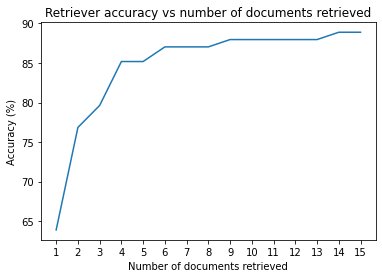

In [11]:
import matplotlib.pyplot as plt

plt.plot(top_k,retrieved_accuracy)
plt.xticks(top_k)
plt.title('Retriever accuracy vs number of documents retrieved')
plt.xlabel('Number of documents retrieved')
plt.ylabel('Accuracy (%)')
plt.savefig('retriever_vs_no_of_docs.jpeg')
plt.show()


In [12]:
question = "Do senior students get any priority?"
documents = retriever.retrieve(query = question, top_k=2)
documents_retrieved = [document.text for document in documents]
documents_retrieved

06/28/2021 16:57:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]


["Allocation Criteria\nBefore you apply, you should understand how our selection process works so that you can maximise your chances of securing a host university. OGEM's selection process is guided by\n\nthe ranking of top three universities in your application\n\nthe no. of available spots per semester and no. of applicants to each partner university. the priority of applicants as stated below. The system shall place students on their 1st university choice first, based on set allocation criteria (priority), before moving on to allocate 2nd university choices to students who did not get their 1st university choice.",
 'Please do not make any payment fee for any administrative matter including visa, air tickets and accommodation until you are advised to do so.']

### Reader evaluation

10 documents will be retrieved for each question. If the documents retrieved does not contain the correct document, the correct document will be appended. 
We will evaluate whether the reader will be able to extract the correct answer from the 10 documents retrieved.

we can see the accuracy is 

#### Get pretrained reader

In [11]:
# Loading trained model

reader = FARMReader('my_model')

06/28/2021 21:53:53 - INFO - farm.utils -   Using device: CUDA 
06/28/2021 21:53:53 - INFO - farm.utils -   Number of GPUs: 1
06/28/2021 21:53:53 - INFO - farm.utils -   Distributed Training: False
06/28/2021 21:53:53 - INFO - farm.utils -   Automatic Mixed Precision: None
06/28/2021 21:53:55 - WARNING - farm.modeling.prediction_head -   Some unused parameters are passed to the QuestionAnsweringHead. Might not be a problem. Params: {"training": true, "num_labels": 2, "ph_output_type": "per_token_squad", "model_type": "span_classification", "label_tensor_name": "question_answering_label_ids", "label_list": ["start_token", "end_token"], "metric": "squad", "name": "QuestionAnsweringHead"}
06/28/2021 21:53:58 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
06/28/2021 21:53:58 - INFO - farm.utils -   Using device: CUDA 
06/28/2021 21:53:58 - INFO - farm.utils -   Number of GPUs: 1
06/28/2021 21:53:58 - INFO - farm.utils -   

In [9]:
from fuzzywuzzy import fuzz

def is_string_match(string1, string2, threshold):
    ratio = fuzz.ratio(string1.lower(),string2.lower())
    return ratio > threshold

C:\Users\hussa\miniconda3\envs\myenv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [10]:
def get_reader_accuracy(question_answer_document, retriever, reader, top_k):
    correctly_predicted = 0
    for question, answer_document in question_answer_document.items():
        documents_retrieved = retriever.retrieve(query = question, top_k=top_k)
        document_texts_retrieved = [document.text for document in documents_retrieved]
        answer = answer_document['answer']
        document = answer_document['context']
        if document in document_texts_retrieved: # Document is correctly retrieved
            retreived_correct_documents = document_texts_retrieved
        else:
            retreived_correct_documents = document_texts_retrieved[:]
            retreived_correct_documents[0] = document
        retrieved_query = reader.predict_on_texts(question, retreived_correct_documents, top_k=1)
        predicted_answer = retrieved_query['answers'][0]['answer']
        if is_string_match(answer, predicted_answer, 70):
            correctly_predicted = correctly_predicted + 1
    return correctly_predicted/len(question_answer_document) * 100

#### Graph of reader accuracy vs documents retrieved

In [16]:
top_k = [x for x in range(1,16)]
retrieved_accuracy = []
for k in top_k:
    accuracy = get_reader_accuracy(question_answer_document, retriever, reader, k)
    retrieved_accuracy.append(accuracy)

06/28/2021 16:58:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.51 Batches/s]
06/28/2021 16:58:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:58:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.15 Batches/s]
06/28/2021 16:58:18 - INFO - elasticsearch -

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:58:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:58:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.49 Batches/s]
06/28/2021 16:58:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:58:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:58:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:58:25 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:25 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:58:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.55 Batches/s]
06/28/2021 16:58:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.59 Batches/s]
06/28/2021 16:58:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:58:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:58:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 16:58:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:58:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:58:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:58:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 16:58:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 16:58:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:58:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:58:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 16:58:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:58:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:41 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:41 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:41 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.62 Batches/s]
06/28/2021 16:58:41 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:58:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:58:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.57 Batches/s]
06/28/2021 16:58:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 16:58:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:58:51 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:58:54 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.51 Batches/s]
06/28/2021 16:58:55 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.54 Batches/s]
06/28/2021 16:58:55 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.08 Batches/s]
06/28/2021 16:58:55 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:58:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.42 Batches/s]
06/28/2021 16:58:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.61 Batches/s]
06/28/2021 16:58:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.17 Batches/s]
06/28/2021 16:58:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.62 Batches/s]
06/28/2021 16:59:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:04 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:59:04 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 16:59:14 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:14 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:59:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 16:59:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 16:59:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:31 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 16:59:34 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 16:59:35 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:35 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:35 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:39 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:40 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:40 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:40 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 16:59:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 16:59:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:48 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.77 Batches/s]
06/28/2021 16:59:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 16:59:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 16:59:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.10 Batches/s]
06/28/2021 16:59:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:54 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 16:59:57 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 16:59:57 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.11 Batches/s]
06/28/2021 16:59:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 16:59:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:00:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:00:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.10 Batches/s]
06/28/2021 17:00:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:00:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:00:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.19 Batches/s]
06/28/2021 17:00:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:00:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:00:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:00:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:00:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:25 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.60 Batches/s]
06/28/2021 17:00:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:00:29 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:29 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.06 Batches/s]
06/28/2021 17:00:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.80 Batches/s]
06/28/2021 17:00:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:00:34 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.61 Batches/s]
06/28/2021 17:00:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.60 Batches/s]
06/28/2021 17:00:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.85 Batches/s]
06/28/2021 17:00:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:42 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:00:42 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:00:42 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:00:43 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:00:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.51 Batches/s]
06/28/2021 17:00:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:00:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:00:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:00:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:54 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:54 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:00:54 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:00:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.61 Batches/s]
06/28/2021 17:00:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:00:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:00:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.62 Batches/s]
06/28/2021 17:01:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:01:04 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:08 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.60 Batches/s]
06/28/2021 17:01:08 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.53 Batches/s]
06/28/2021 17:01:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:01:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:01:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:01:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:01:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.55 Batches/s]
06/28/2021 17:01:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:25 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:01:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.62 Batches/s]
06/28/2021 17:01:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.53 Batches/s]
06/28/2021 17:01:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:31 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:01:31 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:35 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:35 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:35 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:39 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:40 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:01:40 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:40 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:01:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 17:01:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 17:01:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:01:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:01:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:01:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:51 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:01:51 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:01:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:55 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:56 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:01:56 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:56 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:01:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:01:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:01:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:01:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:02:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:02:04 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:02:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.61 Batches/s]
06/28/2021 17:02:08 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:08 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:02:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:02:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:02:14 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:02:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.62 Batches/s]
06/28/2021 17:02:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.62 Batches/s]
06/28/2021 17:02:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:02:25 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:29 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:29 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:29 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:02:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 17:02:34 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:34 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:02:39 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:02:42 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:02:43 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:02:43 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:02:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:02:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.61 Batches/s]
06/28/2021 17:02:48 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:02:48 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:02:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:02:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:02:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:02:57 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:02:57 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:02:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:02:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.51 Batches/s]
06/28/2021 17:03:01 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.59 Batches/s]
06/28/2021 17:03:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:03:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:08 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:03:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:03:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:03:25 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.61 Batches/s]
06/28/2021 17:03:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:03:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:03:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.58 Batches/s]
06/28/2021 17:03:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:03:31 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:03:34 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:03:35 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:35 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:03:39 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:03:39 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:03:40 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:40 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:44 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:03:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.53 Batches/s]
06/28/2021 17:03:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:03:48 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:03:54 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.59 Batches/s]
06/28/2021 17:03:54 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:03:55 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:03:58 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:03:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.58 Batches/s]
06/28/2021 17:03:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:04:00 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:04:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:04:03 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:04:04 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:04:04 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:04:08 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:08 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:04:09 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:04:09 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:04:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:13 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:14 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:14 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.60 Batches/s]
06/28/2021 17:04:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:04:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.52 Batches/s]
06/28/2021 17:04:18 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:04:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.67 Batches/s]
06/28/2021 17:04:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:04:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:04:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.62 Batches/s]
06/28/2021 17:04:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:27 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:04:27 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:04:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:04:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.52 Batches/s]
06/28/2021 17:04:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:04:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:04:41 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:41 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:04:42 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:42 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:04:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:04:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.63 Batches/s]
06/28/2021 17:04:51 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:04:51 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:04:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.58 Batches/s]
06/28/2021 17:04:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:56 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.60 Batches/s]
06/28/2021 17:04:56 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:57 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:04:57 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:00 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:05:01 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.10 Batches/s]
06/28/2021 17:05:01 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:05 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:05:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:05:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:05:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:05:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 17:05:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:05:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.92 Batches/s]
06/28/2021 17:05:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:05:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:05:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:23 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:05:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:27 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:27 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:28 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:05:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.62 Batches/s]
06/28/2021 17:05:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:05:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:05:41 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:42 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:42 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:43 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.61 Batches/s]
06/28/2021 17:05:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:05:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:05:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:51 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:05:51 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:05:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:05:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:56 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.06 Batches/s]
06/28/2021 17:05:56 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:05:57 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:05:57 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:06:00 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.10 Batches/s]
06/28/2021 17:06:01 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:01 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:06:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:06:05 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.59 Batches/s]
06/28/2021 17:06:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 17:06:06 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 17:06:07 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:06:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:10 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.59 Batches/s]
06/28/2021 17:06:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:06:15 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:06:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:06:17 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.18 Batches/s]
06/28/2021 17:06:19 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.61 Batches/s]
06/28/2021 17:06:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:06:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:24 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.002s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57 Batches/s]
06/28/2021 17:06:25 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:06:29 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11 Batches/s]
06/28/2021 17:06:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:06:30 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:06:31 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

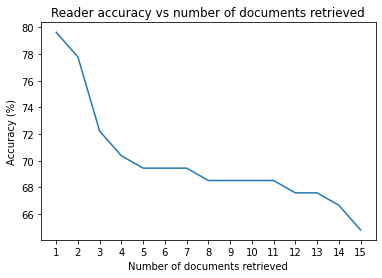

In [20]:
import matplotlib.pyplot as plt

plt.plot(top_k,retrieved_accuracy)
plt.xticks(top_k)
plt.title('Reader accuracy vs number of documents retrieved')
plt.xlabel('Number of documents retrieved')
plt.ylabel('Accuracy (%)')
plt.savefig('reader_vs_no_of_docs.jpeg')
plt.show()

### Comparing different pretrained models

DistilBERT -> 'distilbert-base-uncased-distilled-squad' <br>
BERT -> 'deepset/bert-base-cased-squad2' <br>
RoBERTa -> 'deepset/roberta-base-squad2' <br>

In [14]:
models = {
    'DistilBERT': 'distilbert-base-uncased-distilled-squad',
    'BERT': 'deepset/bert-base-cased-squad2',
    'RoBERTa': 'deepset/roberta-base-squad2'
}

#### DistilBERT

In [13]:
from haystack.reader.farm import FARMReader  

train_data = "data"
train_filename = "answers.json"

model_name = models['DistilBERT']
print("Running model {}".format(model_name))
# Load pre trained model
reader = FARMReader(model_name_or_path=model_name, use_gpu=True)
# Fine tune on our dataset
reader.train(data_dir=train_data, train_filename=train_filename, use_gpu=True, n_epochs=5, save_dir="my_model")

# Evaluate reader
distillbert_accuracy = get_reader_accuracy(question_answer_document, retriever, reader, 5)
distillbert_accuracy

06/28/2021 17:29:21 - INFO - farm.utils -   Using device: CUDA 
06/28/2021 17:29:21 - INFO - farm.utils -   Number of GPUs: 1
06/28/2021 17:29:21 - INFO - farm.utils -   Distributed Training: False
06/28/2021 17:29:21 - INFO - farm.utils -   Automatic Mixed Precision: None


Running model distilbert-base-uncased-distilled-squad


06/28/2021 17:29:31 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
06/28/2021 17:29:31 - INFO - farm.utils -   Using device: CUDA 
06/28/2021 17:29:31 - INFO - farm.utils -   Number of GPUs: 1
06/28/2021 17:29:31 - INFO - farm.utils -   Distributed Training: False
06/28/2021 17:29:31 - INFO - farm.utils -   Automatic Mixed Precision: None
06/28/2021 17:29:31 - INFO - farm.infer -   Got ya 7 parallel workers to do inference ...
06/28/2021 17:29:31 - INFO - farm.infer -    0    0    0    0    0    0    0 
06/28/2021 17:29:31 - INFO - farm.infer -   /w\  /w\  /w\  /w\  /w\  /w\  /w\
06/28/2021 17:29:31 - INFO - farm.infer -   /'\  / \  /'\  /'\  / \  / \  /'\
06/28/2021 17:29:31 - INFO - farm.infer -               
06/28/2021 17:29:32 - INFO - farm.utils -   Using device: CUDA 
06/28/2021 17:29:32 - INFO - farm.utils -   Number of GPUs: 1
06/28/2021 17:29:32 - INFO - farm.utils -   Distributed Training: False
06/28/2021 1

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:31:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.42 Batches/s]
06/28/2021 17:31:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:31:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.82 Batches/s]
06/28/2021 17:31:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:31:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.10 Batches/s]
06/28/2021 17:31:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:31:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.83 Batches/s]
06/28/2021 17:31:50 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.17 Batches/s]
06/28/2021 17:31:54 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.81 Batches/s]
06/28/2021 17:31:55 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:31:55 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.58 Batches/s]
06/28/2021 17:31:55 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:31:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.13 Batches/s]
06/28/2021 17:31:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14 Batches/s]
06/28/2021 17:31:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56 Batches/s]
06/28/2021 17:31:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.003s]
Inferencing Samples: 100%|██████████████████

63.888888888888886

#### BERT

In [12]:
from haystack.reader.farm import FARMReader  

train_data = "data"
train_filename = "answers.json"

model_name = models['BERT']
print("Running model {}".format(model_name))
# Load pre trained model
reader = FARMReader(model_name_or_path=model_name, use_gpu=False)
# Fine tune on our dataset
reader.train(data_dir=train_data, train_filename=train_filename, use_gpu=False, n_epochs=5, save_dir="my_model")

# Evaluate reader
bert_accuracy = get_reader_accuracy(question_answer_document, retriever, reader, 5)
bert_accuracy

06/28/2021 21:00:14 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.012s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28 Batches/s]
06/28/2021 21:00:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.010s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85 Batches/s]
06/28/2021 21:00:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.113s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33 Batches/s]
06/28/2021 21:00:26 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.010s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33 Batches/s]
06/28/2021 21:00:26 - INFO - elasticsearch -

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:00:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.007s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46 Batches/s]
06/28/2021 21:00:32 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.006s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88 Batches/s]
06/28/2021 21:00:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.006s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33 Batches/s]
06/28/2021 21:00:33 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.007s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46 Batches/s]
06/28/2021 21:00:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.016s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:00:36 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:00:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.007s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46 Batches/s]
06/28/2021 21:00:37 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88 Batches/s]
06/28/2021 21:00:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.68 Batches/s]
06/28/2021 21:00:45 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33 Batches/s]
06/28/2021 21:00:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:00:46 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.006s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.99 Batches/s]
06/28/2021 21:00:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.47 Batches/s]
06/28/2021 21:00:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.006s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33 Batches/s]
06/28/2021 21:00:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:00:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.48 Batches/s]
06/28/2021 21:00:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46 Batches/s]
06/28/2021 21:01:00 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:01:00 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:01:00 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.006s]
Inferencing Samples: 100%|██████████████████

75.0

#### RoBERTa

In [12]:
from haystack.reader.farm import FARMReader  

train_data = "data"
train_filename = "answers.json"

model_name = models['RoBERTa']
print("Running model {}".format(model_name))
# Load pre trained model
reader = FARMReader(model_name_or_path=model_name, use_gpu=False)
# Fine tune on our dataset
reader.train(data_dir=train_data, train_filename=train_filename, use_gpu=False, n_epochs=5, save_dir="my_model")

# Evaluate reader
roberta_accuracy = get_reader_accuracy(question_answer_document, retriever, reader, 5)
roberta_accuracy

06/28/2021 21:54:27 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.66 Batches/s]
06/28/2021 21:54:34 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.063s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:54:38 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.014s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80 Batches/s]
06/28/2021 21:54:39 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.114s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.87 Batches/s]
06/28/2021 21:54:39 - INFO - elasticsearch -

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:54:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31 Batches/s]
06/28/2021 21:54:47 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88 Batches/s]
06/28/2021 21:54:48 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.88 Batches/s]
06/28/2021 21:54:48 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.87 Batches/s]
06/28/2021 21:54:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.023s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:54:52 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46 Batches/s]
06/28/2021 21:54:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.45 Batches/s]
06/28/2021 21:54:53 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.012s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:55:01 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.011s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.31 Batches/s]
06/28/2021 21:55:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.006s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.45 Batches/s]
06/28/2021 21:55:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33 Batches/s]
06/28/2021 21:55:02 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.017s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:55:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34 Batches/s]
06/28/2021 21:55:11 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:55:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.005s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:55:12 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.011s]
Inferencing Samples: 100%|██████████████████

Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:55:20 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.008s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:55:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.004s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.89 Batches/s]
06/28/2021 21:55:21 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
Inferencing Samples: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.45 Batches/s]
06/28/2021 21:55:22 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.009s]
Inferencing Samples: 100%|██████████████████

91.66666666666666

In [14]:
model_accuracy = models = {
    'DistilBERT': distillbert_accuracy,
    'BERT': bert_accuracy,
    'RoBERTa': roberta_accuracy
}

#### Lets plot bar graph to compare accuracy of the 3 pre trained models

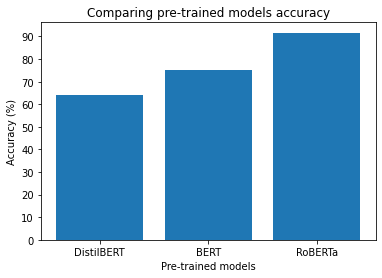

In [24]:
import matplotlib.pyplot as plt

model_names = models.keys()
model_accuracy = models.values()
plt.yticks([x for x in range(0, 100, 10)])
plt.bar(model_names,model_accuracy)
plt.title('Comparing pre-trained models accuracy')
plt.xlabel('Pre-trained models')
plt.ylabel('Accuracy (%)')
plt.savefig('pre-trained model accuracy.jpeg')
plt.show()